In [1]:
import pandas as pd
df_ml = pd.read_csv("../data/processed/FalabellaAyuda_2022-12-27.csv")
df_ml.dropna(subset=["tweet_text"], inplace=True)
# df_ml = df_ml[df_ml["sentiment"] != "others"]
df_ml["longitud_text"] = df_ml["tweet_text"].apply(len)
df_ml = df_ml[df_ml["longitud_text"] > 84.0]
df_ml = df_ml.sample(n=100, random_state=42)
df_ml.shape

(100, 9)

In [2]:
def df_to_list(df):
    texts = df["tweet_text"]
    data = []
    for text in texts:
        data.append(text)
    return data

In [3]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from src import Features
inputs = df_to_list(df_ml)
inputs = Features.bert_encoder(inputs, tokenizer_español)

In [5]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [6]:
max_poll = Features.max_polling(last_hidden_states)
mean_poll = Features.mean_polling(last_hidden_states)

In [7]:
data_ml = {
        "Beto+maxPolling+stdN": Features.std_normalization(max_poll),
        "Beto+maxPolling+zScore": Features.z_score_normalization(max_poll),
        "Beto+maxPolling+minMax": Features.min_max_normalization(max_poll),
        "Beto+meanPolling+stdN": Features.std_normalization(mean_poll),
        "Beto+meanPolling+zScore": Features.z_score_normalization(mean_poll),
        "Beto+meanPolling+minMax": Features.min_max_normalization(mean_poll),
    }

In [8]:
def find_indexs(list, value):
    list_aux = list.copy()
    output = []
    while True:
        try:
            index = list_aux.index(value)
            output.append(index)
            list_aux[index] = None
        except ValueError:
            break
    return output

# agrupamiento

In [9]:
import sys

valor_minimo = sys.float_info.min
print(valor_minimo)

2.2250738585072014e-308


# k-means

In [10]:
# k-means
from sklearn.cluster import KMeans
from sklearn import metrics
agrupamiento = {}
metricas = {}
for K in range(2, 8):
    si = []
    vp = []
    for key, value in data_ml.items():
        if key not in metricas:
            metricas[key] = {
                "silhouettes_by_k_centroids": [],
                "VP_by_k_centroids": [],
            }
        # value shape: (77, 768)
        value = np.array(value)
        kmeans = KMeans(
            n_clusters=K,
            init="random",
            max_iter=10000,
            random_state=42,
            n_init=42,
        )
        cluster_labels = kmeans.fit_predict(value)
        centers = kmeans.cluster_centers_
        agrupamiento[key] = list(cluster_labels)
        variances = []
        for k in range(K):
            variance = Features.cluster_variance(value, cluster_labels, centers, k)
            variances.append(variance)
        avg_variance = sum(variances)/len(variances)
        vp.append(avg_variance)
        si.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["silhouettes_by_k_centroids"].append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["VP_by_k_centroids"].append(avg_variance)

metricas

{'Beto+maxPolling+stdN': {'silhouettes_by_k_centroids': [0.08808749621781942,
   0.11415947145408811,
   0.04111628121921544,
   0.021395125201539137,
   0.047237929895447034,
   0.050615532065580865],
  'VP_by_k_centroids': [7.971946714972427e-07,
   6.077326373262069e-07,
   6.161484991570975e-07,
   6.584659679742615e-07,
   3.775129954953268e-07,
   6.671657704303693e-07]},
 'Beto+maxPolling+zScore': {'silhouettes_by_k_centroids': [0.036187690241889704,
   0.018925343164507395,
   0.017157079283470867,
   0.013925427589808297,
   0.014984496008555472,
   0.016348467581484633],
  'VP_by_k_centroids': [0.736220319121204,
   0.6859468384001347,
   0.6356864841007803,
   0.7121165242334009,
   0.6812222431315943,
   0.5604486661717492]},
 'Beto+maxPolling+minMax': {'silhouettes_by_k_centroids': [0.5912605339884813,
   0.5020402683576736,
   0.42236808258975667,
   0.3664145120004638,
   0.3216468544670472,
   0.24826786284370364],
  'VP_by_k_centroids': [0.06332907258618661,
   0.02636

In [11]:
ops = []
opv = []
print(" & Número de grupos & Medida Silhouette & Medida VP")
for metricas_key in metricas.keys():
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = metricas[metricas_key]["VP_by_k_centroids"]
    idx_optimo = Features.optimo_k(sI, vP)
    ops.append(sI[idx_optimo])
    opv.append(vP[idx_optimo])
    print(f"{metricas_key} & {idx_optimo + 2} & {sI[idx_optimo]:.4f} & {vP[idx_optimo]:.4f}")
op_grouping = list(metricas.keys())[Features.optimo_k(ops, opv)]
# print(list(metricas.keys())[best])
# best = Features.optimo_k(ops, opv)
# op_grouping = f"({ops[best]}, {opv[best]})"
print(f"siMax: {max(ops):.4f}, vMinx: {min(opv):.4f}, op: {op_grouping}")

 & Número de grupos & Medida Silhouette & Medida VP
Beto+maxPolling+stdN & 3 & 0.1142 & 0.0000
Beto+maxPolling+zScore & 7 & 0.0163 & 0.5604
Beto+maxPolling+minMax & 2 & 0.5913 & 0.0633
Beto+meanPolling+stdN & 2 & 0.1335 & 0.0000
Beto+meanPolling+zScore & 7 & 0.0420 & 0.3611
Beto+meanPolling+minMax & 2 & 0.3265 & 0.0021
siMax: 0.5913, vMinx: 0.0000, op: Beto+maxPolling+minMax


# Visualización de los resultados de la metricas para encontrar el k-óptimo.

optimo: 1 , x(optimo): 3, y(optimo): 0.11415947145408811
optimo: 5 , x(optimo): 7, y(optimo): 0.016348467581484633
optimo: 0 , x(optimo): 2, y(optimo): 0.5912605339884813
optimo: 0 , x(optimo): 2, y(optimo): 0.13353531266435842
optimo: 5 , x(optimo): 7, y(optimo): 0.04202116865972215
optimo: 0 , x(optimo): 2, y(optimo): 0.32648104995691823


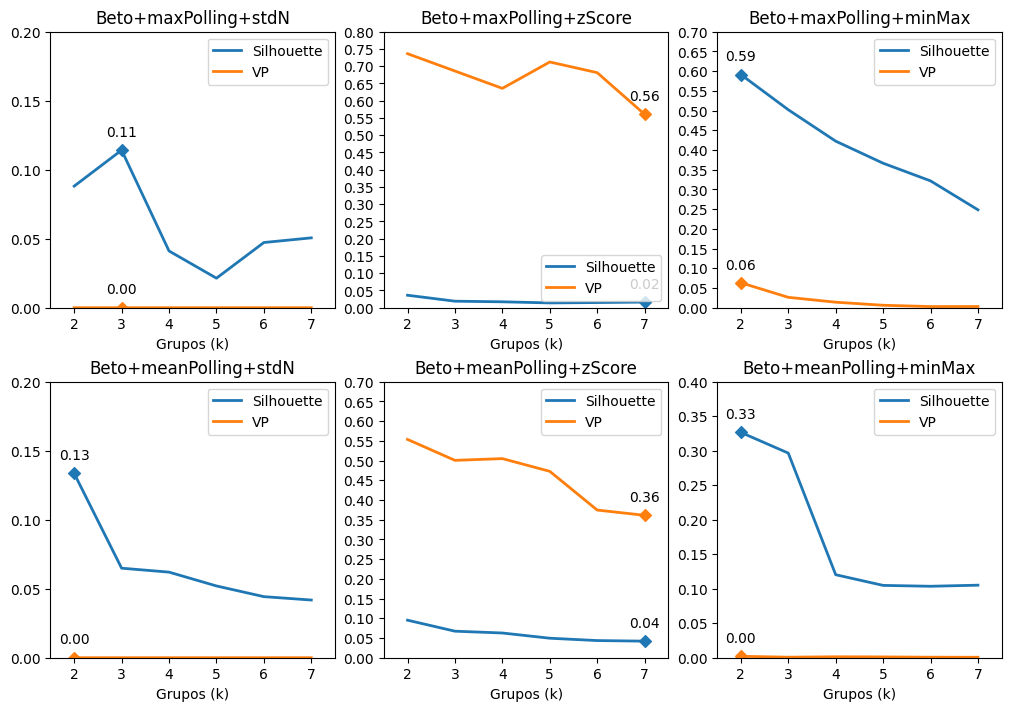

In [12]:
import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')
x = range(2, 8)
k_optimos = []
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7),
                        layout="constrained")
for ax, metricas_key in zip(axs.flat, metricas.keys()):
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = metricas[metricas_key]["VP_by_k_centroids"]
    # vP, p = Features.decimal_scaling_normalization(np.array(metricas[metricas_key]["VP_by_k_centroids"]))
    # p = f"/ {p}" if p >= 10 else ""
    optimo = Features.optimo_k(sI, list(vP))
    k_optimos.append(optimo)
    print(f"optimo: {optimo} , x(optimo): {x[optimo]}, y(optimo): {sI[optimo]}")
    # plot

    ax.plot(x, sI, linewidth=2.0, label="Silhouette")
    ax.plot(x, vP, linewidth=2.0, label=f"VP")
    ax.scatter([x[optimo]], [sI[optimo]], marker="D")
    ax.scatter(x[optimo], vP[optimo], marker="D")
    y_max_lim = max([max(vP), max(sI)])
    y_max_lim = round(y_max_lim, 1) + 0.1
    # y_max_lim = 1.0 if y_max_lim >= 1.0 else y_max_lim
    y_min_lim = min([min(vP), min(sI)])
    y_min_lim = round(y_min_lim, 1) - 0.05 if y_min_lim < 0.0 else 0.0
    ax.set(xlim=(x[0] - 0.5, x[-1] + 0.5), xticks=np.arange(x[0], x[-1] + 1),
        ylim=(y_min_lim, y_max_lim), yticks=np.arange(y_min_lim, y_max_lim + 0.05, 0.05))
    ax.set_xlabel("Grupos (k)")

    label0 = "{:.2f}".format(sI[optimo])
    ax.annotate(label0,
                (x[optimo],sI[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    label1 = "{:.2f}".format(vP[optimo])
    ax.annotate(label1,
                (x[optimo],vP[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax.set_title(f"{metricas_key}")
    ax.legend()
k_optimos = np.array(k_optimos) + 2

plt.show()

# visualización de resultados de analisis de sentimiento en los grupos creados

In [13]:
k_optimos

array([3, 7, 2, 2, 7, 2])

In [14]:
traduccion = {
    "sadness": "tristeza",
    "joy": "alegría",
    "anger": "enojo",
    "surprise": "sorpresa",
    "disgust": "rechazo",
    "Fear": "miedo",
    "others": "otros"
}

In [15]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=k_optimos[i],
        init="random",
        max_iter=10000,
        random_state=42,
        n_init=42,
    ).fit(value)
    agrupamiento[key] = [list(kmeans.labels_), k_optimos[i]]
    i += 1

clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {}
    for k in range(value[1]):
        clusters[key][f"grupo {k + 1}"] = df_ml.iloc[find_indexs(agrupamiento[key][0], k)]

# preprocesado vs sentimiento.
sentiment_analysis = {}
i=0
for kesI, value0 in clusters.items():
    sentiment_analysis[kesI] = {}
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment_analysis[kesI][kevP] = {f"{traduccion[label]}": value for label, value in zip(sentiment_labels, sentiment_values)}

sentiment_analysis


{'Beto+maxPolling+stdN': {'grupo 1': {'enojo': 40,
   'otros': 28,
   'tristeza': 4,
   'alegría': 1},
  'grupo 2': {'otros': 7, 'enojo': 1},
  'grupo 3': {'otros': 14, 'enojo': 2, 'tristeza': 2, 'alegría': 1}},
 'Beto+maxPolling+zScore': {'grupo 1': {'otros': 7, 'enojo': 3},
  'grupo 2': {'otros': 9, 'enojo': 6},
  'grupo 3': {'otros': 7, 'enojo': 4, 'tristeza': 2, 'alegría': 1},
  'grupo 4': {'enojo': 18, 'otros': 6, 'tristeza': 4},
  'grupo 5': {'otros': 20, 'enojo': 5, 'alegría': 1},
  'grupo 6': {'enojo': 4},
  'grupo 7': {'enojo': 3}},
 'Beto+maxPolling+minMax': {'grupo 1': {'otros': 27,
   'enojo': 19,
   'alegría': 1},
  'grupo 2': {'enojo': 24, 'otros': 22, 'tristeza': 6, 'alegría': 1}},
 'Beto+meanPolling+stdN': {'grupo 1': {'otros': 26,
   'enojo': 14,
   'tristeza': 2},
  'grupo 2': {'enojo': 29, 'otros': 23, 'tristeza': 4, 'alegría': 2}},
 'Beto+meanPolling+zScore': {'grupo 1': {'enojo': 1},
  'grupo 2': {'enojo': 11, 'otros': 8, 'tristeza': 1},
  'grupo 3': {'otros': 5},


In [16]:
lst = [[1,2,3], [3,3]]
def colours(lst):
    print(lst)
    outer = []
    inner = []
    outer_colours = [0, 2, 4, 8, 10, 12, 14]
    inner_colours = range(28)
    i0 = 0
    i1 = 0
    for l in lst:
        outer.append(outer_colours[i0])
        for _ in l:
            inner.append(inner_colours[i1])
            i1 += 1
        i0 += 1
        i1 = i0 * 4
    return outer, inner
colours(lst)

[[1, 2, 3], [3, 3]]


([0, 2], [0, 1, 2, 4, 5])

In [17]:
def list_flatten(lst):
    outputs = []
    for l in lst:
        for e in l:
            outputs.append(e)
    return outputs

[[40, 28, 4, 1], [7, 1], [14, 2, 2, 1]]
[[7, 3], [9, 6], [7, 4, 2, 1], [18, 6, 4], [20, 5, 1], [4], [3]]
[[27, 19, 1], [24, 22, 6, 1]]
[[26, 14, 2], [29, 23, 4, 2]]
[[1], [11, 8, 1], [5], [3, 1], [19, 9, 1], [13, 3, 3, 1], [11, 8, 1, 1]]
[[29, 21, 1], [22, 20, 5, 2]]


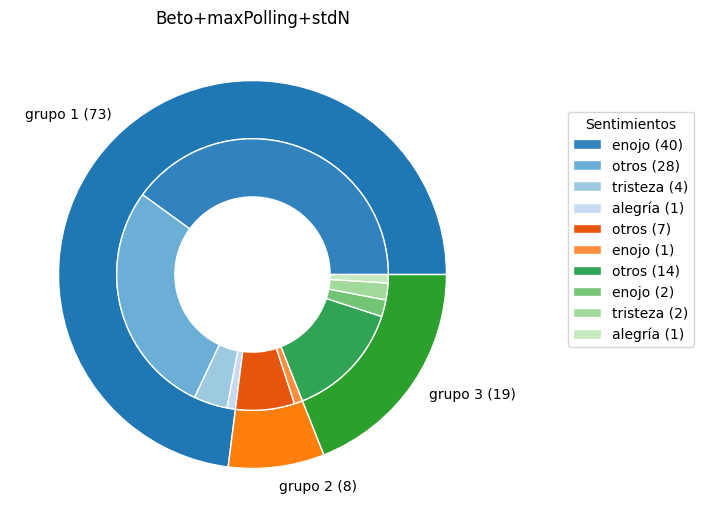

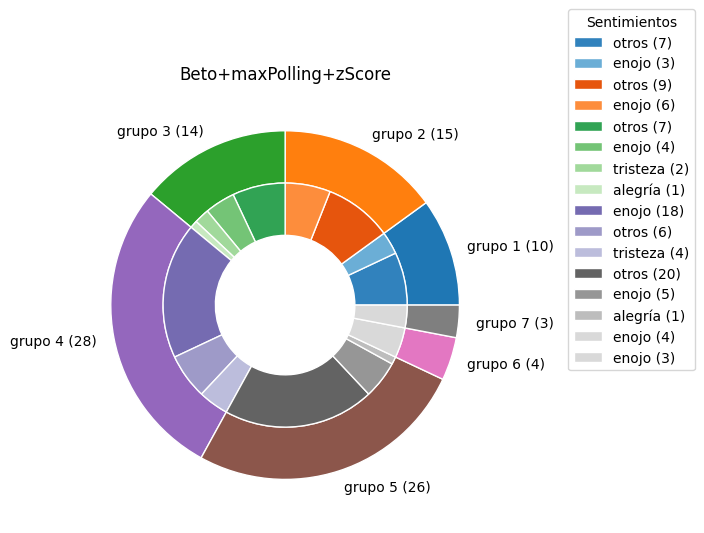

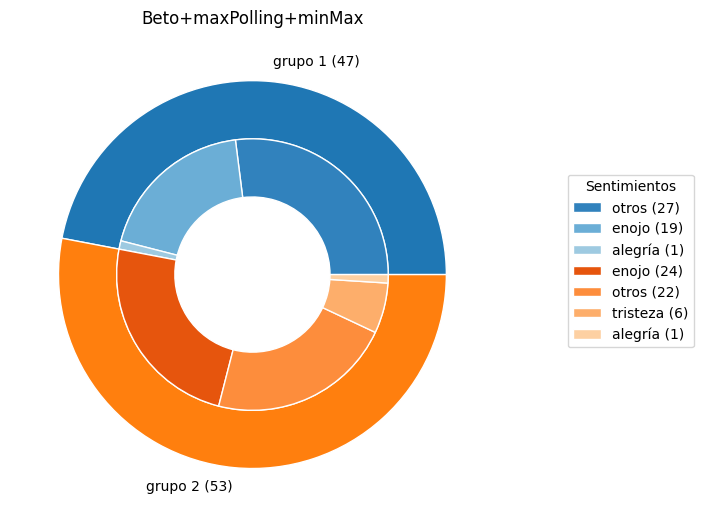

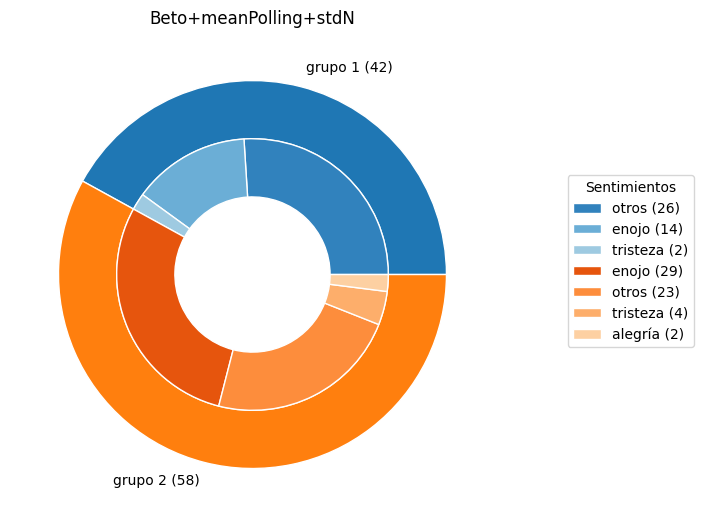

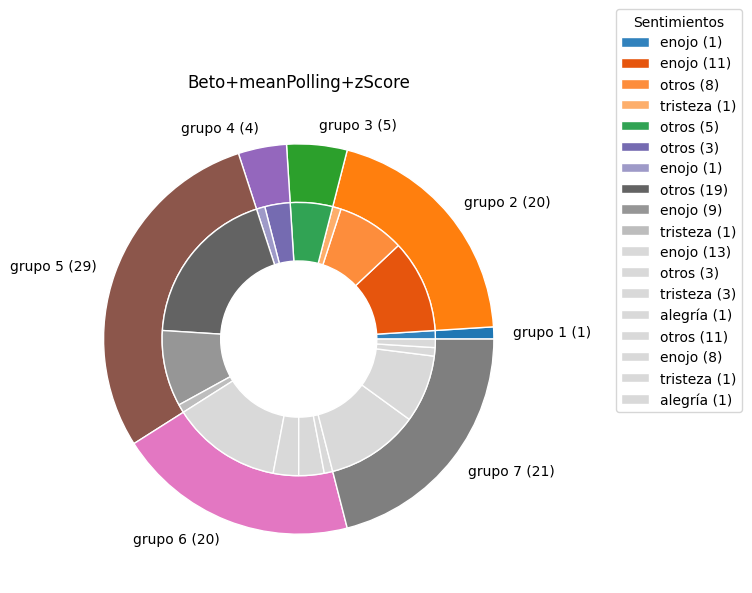

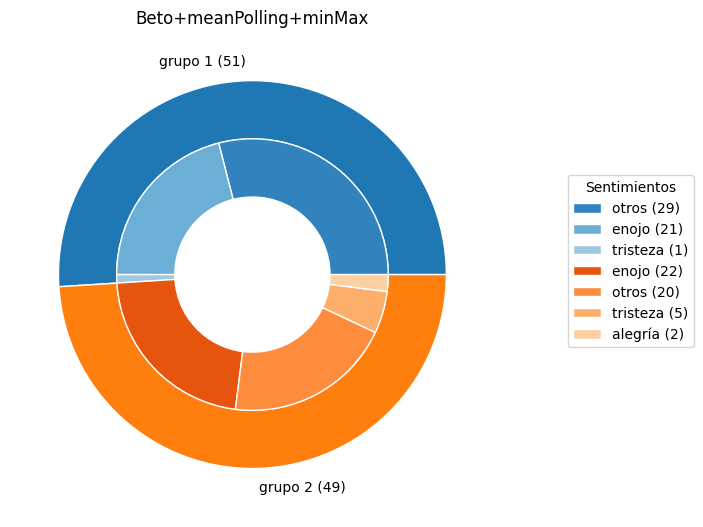

In [18]:
for key in sentiment_analysis.keys():
       fig, ax = plt.subplots(figsize=(7, 6),
                        layout="constrained")
       size = 0.3
       clusters_names = sentiment_analysis[key].keys()
       clusters_sentiments = [list(sentiment_analysis[key][c].keys()) for c in clusters_names]
       clusters_sentiments = list_flatten(clusters_sentiments)
       vals = [list(sentiment_analysis[key][c].values()) for c in clusters_names]
       clusters_names = [f"{c} ({sum(v)})" for c, v in zip(clusters_names, vals)]
       clusters_sentiments = [f"{s} ({v})" for s, v in zip(clusters_sentiments, list_flatten(vals))]

       outer_cmap = plt.get_cmap("tab20")
       inner_cmap = plt.get_cmap("tab20c")
       outer_colors, inner_colors = colours(vals)
       outer_colors = outer_cmap(np.array(outer_colors))
       inner_colors = inner_cmap(np.array(inner_colors))

       sum_vals = [sum(list(i)) for i in vals]
       ax.pie(sum_vals, radius=1, colors=outer_colors, labels=clusters_names,
              wedgeprops=dict(width=size, edgecolor='w'))

       ax.pie(list_flatten(vals), radius=1-size, colors=inner_colors, labels=[" " for _ in clusters_sentiments],
              labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

       ax.set(aspect="equal", title=f'{key}')
       handles, labels = ax.get_legend_handles_labels()

       ax.legend(handles[len(clusters_names):], clusters_sentiments, loc=(1.15, 0.35), title="Sentimientos")

plt.show()

# Extracción de información

In [19]:
# Example usage
corpus = {}
key_list = list(clusters.keys())
for k in key_list:
    corpus[k] = {}
    for key, value0 in clusters[k].items():
        corpus[k][key] = {
            "text": value0['tweet_text'].tolist(),
            "sentiment": value0['sentiment'].tolist()
        }
        # corpus.append(value0['tweet_text'].tolist())
corpus[op_grouping]

{'grupo 1': {'text': ['en tienda por una compra fue cobrada doble, la persona a traves de fpay paso dos veces mi compra y tengo un cobre doble, llevo toda la semana esperando una respuesta y nada',
   'cuando me van a solucionar tengamos de una semana haciendo el reclamo no llego el regalo de mi hija de navidad y aun son incapaz de dar respuesta de donde esta el producto que pague no ayudan y son pesimos gestionando ayudaaa',
   'necesito saber como proceder con un smart tv que compre el 9 de noviembre y no funciona, llame al call center pero me manda a la app en la cual no esta la opcion de cambio en la seccion mis compras, agradeceria informacion',
   'pedi un regalo para hija y me dice que el despacho era para el 21 y aun no llega!! se pasaron para irresponsables.',
   'hasta cuando tengo que esperar??? ya pasaron las 72 hrs extras que ustedes dijeron, me estan cambiando las fechas',
   'hola! puedo hacer un cambio con la foto del ticket de cambio??? sale claramente el codigo y los 

In [20]:
from src import Summarize
from sklearn.feature_extraction.text import CountVectorizer
sumarize = Summarize()
vectorizer = CountVectorizer()
# todolos lo procesados
# for k in key_list:
#     tcre_results[k] = {}
#     corpus0 = []
#     cluster_result = []
#     grupo = 0
#     for key, value in corpus[k].items():
#         corpus0 += value
#         cluster_result += [grupo]*len(value)
#         grupo += 1 
#     tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
#     for indx, v in enumerate(tcre):
#         tcre_results[k][f"grupo {indx + 1}"] = v[:int(len(v)*0.5)]

# el mejor procesado.
tcre_results = {}
corpus0 = []
cluster_result = []
grupo = 0
for key, value in corpus[op_grouping].items():
    corpus0 += value["text"]
    cluster_result += [grupo]*len(value["text"])
    grupo += 1 
tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
for indx, v in enumerate(tcre):
    tcre_results[f"grupo {indx + 1}"] = v[:int(len(v)*0.3)]
tcre_results

{'grupo 1': ['pizza',
  'otras',
  'tampoco',
  'molestias',
  'deberia',
  '2022',
  'los',
  'chat',
  'modelo',
  'esto',
  'compra',
  'adm',
  'smart',
  'escriba',
  'pueden',
  'sobrinos',
  'inconcebible',
  'pero',
  'que',
  'falta',
  'persona',
  'loco',
  'antes',
  'igual',
  'corto',
  'pasado',
  'hecha',
  'problemas',
  'envian',
  'llevo'],
 'grupo 2': ['darme',
  'cada',
  'espere',
  'papa',
  'direccion',
  'deuda',
  'cancelados',
  'tan',
  'verguenza',
  'web',
  'opcion',
  'jo',
  'ayudar',
  'cundo',
  'descuento',
  'gus',
  'entrega',
  'denme',
  'hacen',
  'demasiado',
  'mata',
  'hija',
  'traspaso',
  'van',
  'paga',
  'le',
  'pague',
  'tiempos',
  'minimo',
  'son']}

In [21]:
# from nltk.tokenize import sent_tokenize

# sentences = sent_tokenize(text2)
vectorizer = CountVectorizer()
# A = vectorizer.fit_transform(sentences).toarray()
# A = A.T
# A.shape
lsa_results = {}

for key, value in corpus[op_grouping].items():
    A = vectorizer.fit_transform(value["text"]).toarray()
    A = A.T
    score_indices = Summarize.LSA_summary(A, 3)
    lsa_results[key] = {
        "Resumen": [value["text"][idx] for idx in score_indices],
        "sentiment": [value["sentiment"][idx] for idx in score_indices]
    }

lsa_results

{'grupo 1': {'Resumen': ['realice una compra que debia llegar el 13 de diciembre, coloque un reclamo y a la fecha nadie se ha contactado conmigo para una solucion, intento cancelar la compra y no se puede ya que dice que la prepararon, que espero ahora si ya no quiero la compra?',
   'hola tengo un problema con un producto que compre por internet, al ir a la pagina web a buscar el ticket de cambio me dice que los documentos se estan procesando, y debo cambiar uno de los productos por que la talla es muy grande, que se puede hacer en este caso.',
   'son unos estafadores....me dicen algo o cumplen se supone que m iban a solucionar y ayer llegaria el regalo de mi hija y nada solo por zafarse de las denuncias antes el no es posible que no hija se quede sin regalo por ustedes que falta de respeto y etica'],
  'sentiment': ['others', 'others', 'anger']},
 'grupo 2': {'Resumen': ['despues de preguntar por 3ra vez por el atrasado de mi entrega me responden que esta sin stock el producto y que